# American sign language neural networks
Add intro, explain overall exercise

## Preparations
### Import libraries

In [667]:
# import basic libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import random_split

from tqdm.auto import tqdm
import cv2
import skimage

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

sns.set(style="darkgrid")
palette = sns.set_palette('rocket')


### Auxiliary functions
On this part we define the classes and functions that will be used through the notebook.

First we define a couple of classes to convert our images in to the dataset/dataloader format that is used by pytorch

Second, we define the train and test function that wil be used in both our neural networks configurations

In [668]:
# Auxiliary functions
# Create custom dataloader object for dataset 1 (28px)
class asl_dataset(torch.utils.data.Dataset):

  def __init__(self, src_file, num_rows=None):
    y_tmp = src_file['label']
    y_tmp = y_tmp.values
    x_tmp = src_file.drop('label', axis=1)
    x_tmp = x_tmp.values
    self.x_data = torch.tensor(x_tmp, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y_tmp, dtype=torch.long).to(device)

  def __len__(self):
    return len(self.x_data)  # required

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = self.x_data[idx, 0:784]
    label = self.y_data[idx]
    #sample = \
    #  { 'pixels' : preds, 'class' : pol }
    return image, label

# Create custom dataloader object for dataset 2 (64 px)
class asl64_dataset(torch.utils.data.Dataset):

  def __init__(self, data, label, num_rows=None):
    y_tmp = label
    #y_tmp = y_tmp.values
    x_tmp = data
    #x_tmp = x_tmp.values
    self.x_data = torch.tensor(x_tmp, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y_tmp, dtype=torch.long).to(device)

  def __len__(self):
    return len(self.x_data)  # required

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = self.x_data[idx, 0:12288]
    label = self.y_data[idx]
    return image, label

accuracy_list = []

def train(model, optimizer, data_loader):
    model.train()

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        data = data.view(-1, channels, img_size, img_size)

        optimizer.zero_grad()
        output = model(data)

        loss = F.cross_entropy(output, target) #cross entropy loss
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(' [{:.0f}/{:.0f}] {:.0f}% Loss: {:.6f}'.format(
                batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))
            
def test(model, data_loader): 
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        
        data = data.view(-1, channels,img_size,img_size)
        
        output = model(data)
        
        test_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(data_loader.dataset),accuracy))
    return accuracy, test_loss

In [669]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load data
We will work with two datasets:

1) a set of about 35k, 28x28px images with 1 channel, coded in a CSV format
2) a set of about 75K 64x64px images with 3 channels

Each of these datasets requires a different loading treatment:

For number 1 we will use and extended dataset class to convert the csv file into a pytorch dataset and dataloader, this will allows us to iterate through the dataset with our specified batch size and use the native coding of our x and y variables

For number 2 the same result as above is achieved by using the ImageLoader library from pytoarch, but we will additionally resize and normalize the images to allow a faster processing. We will rescale from 64px to 32px. 

In [670]:
# define batch size
batch_size = 100

# load dataset 1 from csv's into a single dataframe
train_data_raw = pd.read_csv('../../data/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('../../data/sign_mnist_test.csv', sep=",")
all_data_raw = pd.concat([train_data_raw,test_data_raw], axis=0)

# convert to pytorch dataset and dataloader
train_data_ds = asl_dataset(train_data_raw)
test_data_ds = asl_dataset(test_data_raw)
train_data_ldr = torch.utils.data.DataLoader(train_data_ds, batch_size=batch_size, shuffle=True)
test_data_ldr = torch.utils.data.DataLoader(test_data_ds, batch_size=len(test_data_ds), shuffle=True)

In [671]:
 
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

# load dataset 2 from image folder
data_dir = 'C:\\Users\\ivano\\Desktop\\DSMMaster\\CMLII\\data\\asl_alphabet\\'
classes = os.listdir(data_dir + "/asl_alphabet_train/asl_alphabet_train")

# set the transform steps for all the images
transform = tt.Compose(
    [
        tt.Resize(32),
        tt.ToTensor(),
        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# read the images into a pytorch dataset
dataset32 = ImageFolder(data_dir+"/asl_alphabet_train/asl_alphabet_train", transform)

# define the train and test datasets
test_size = int(round(len(dataset32)*0.2,0))
train_size = len(dataset32) - test_size
train_data32_ds, test_data32_ds = random_split(dataset32, [train_size, test_size])

# set the pytoarch loaders
train_data32_ldr = torch.utils.data.DataLoader(train_data32_ds, batch_size=batch_size, shuffle=True)
test_data32_ldr = torch.utils.data.DataLoader(test_data32_ds, batch_size=len(test_data32_ds), shuffle=True)

This is a preview of 28pixels dataset

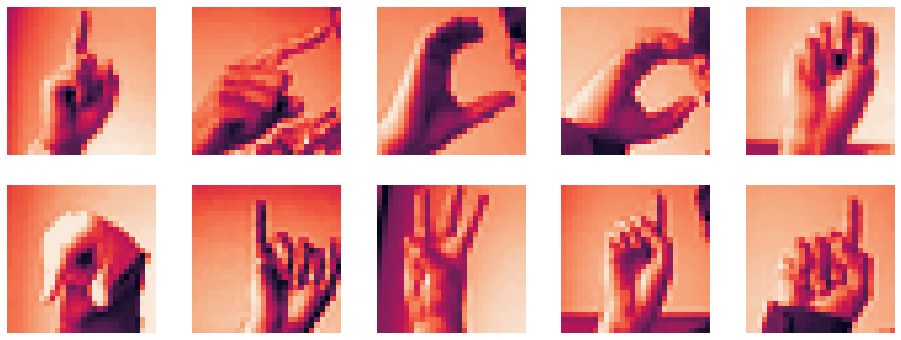

In [672]:
img_size = 28  
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_data_ldr.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy().reshape(img_size,img_size))
    plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


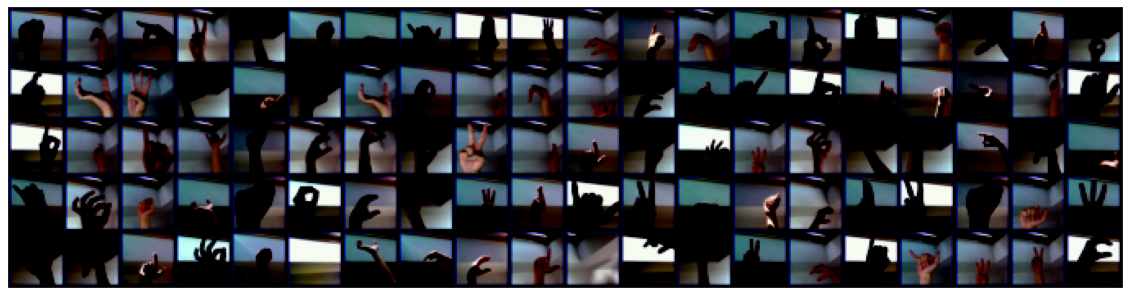

In [673]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1,2,0))
        break

show_batch(train_data32_ldr)


## Simple network case

### Set parameters
For the simple network we will apply a simple architecture with the following parameters
- 20 epochs
- fixed learning rate = 0.0001
- 256 hidden units

In [674]:
channels = 1
img_size = 28     
in_size = img_size*img_size*channels
out_size = 26           # number of classes
n_feat = img_size*img_size
epochs = 10
learning_rate = 0.0001
gamma = 1
momentum = 0.9
n_hidden = 512        # number of hidden units


### Define network architecture
Explain each component of the architecture selected

In [675]:
# Create network arquitectures
# simplest NN architecture
class simple(nn.Module):
    def __init__(self, in_size, n_hidden, out_size):
        super(simple, self).__init__()
        self.in_size = in_size
        self.n_hidden = n_hidden
        self.out_size = out_size
        self.network = nn.Sequential(
            nn.Linear(self.in_size, self.n_hidden), 
            nn.ReLU(), 
            nn.Linear(self.n_hidden, 30*2*2),
            nn.ReLU(), 
            nn.Linear(30*2*2, out_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.in_size)
        return self.network(x)


### Instantiate and train/test network model
Explain optimization algorithm and scheduler

In [676]:
import torch.optim.lr_scheduler

model_fnn = simple(in_size, n_hidden, out_size) # simple
model_fnn.to(device)
optimizer = torch.optim.Adam(model_fnn.parameters(),lr=learning_rate)

summary(model_fnn, input_size = (channels,img_size,img_size), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 120]          61,560
              ReLU-4                  [-1, 120]               0
            Linear-5                   [-1, 26]           3,146
        LogSoftmax-6                   [-1, 26]               0
Total params: 466,626
Trainable params: 466,626
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.78
Estimated Total Size (MB): 1.79
----------------------------------------------------------------


In [677]:
results = pd.DataFrame()

for epoch in range(0, epochs):
    temp = pd.DataFrame()

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    print('Epoch = '+str(epoch)+' Learning Rate = ',optimizer.param_groups[0]["lr"])
    
    train( model_fnn, optimizer, train_data_ldr)
    accuracy, loss = test(model_fnn, test_data_ldr)
    
    temp['nn'], temp['epoch'], temp['accuracy'], temp['loss'] = zip(['simple',epoch,accuracy,loss])
    results = results.append(temp)

    scheduler.step()

results = results.reset_index()
results_simple = results.drop('index', axis=1)

Epoch = 0 Learning Rate =  0.0001
 [0/27455] 0% Loss: 22.846670
 [10000/27455] 36% Loss: 2.424624
 [20000/27455] 73% Loss: 1.487941

Test set: Average loss: 1.8424, Accuracy: 3216/7172 (45%)

Epoch = 1 Learning Rate =  0.0001
 [0/27455] 0% Loss: 1.306831
 [10000/27455] 36% Loss: 0.900406
 [20000/27455] 73% Loss: 0.884501

Test set: Average loss: 1.5014, Accuracy: 3979/7172 (55%)

Epoch = 2 Learning Rate =  0.0001
 [0/27455] 0% Loss: 0.621311
 [10000/27455] 36% Loss: 0.583924
 [20000/27455] 73% Loss: 0.640126

Test set: Average loss: 1.2990, Accuracy: 4565/7172 (64%)

Epoch = 3 Learning Rate =  0.0001
 [0/27455] 0% Loss: 0.511686
 [10000/27455] 36% Loss: 0.383292
 [20000/27455] 73% Loss: 0.268809

Test set: Average loss: 1.1923, Accuracy: 4767/7172 (66%)

Epoch = 4 Learning Rate =  0.0001
 [0/27455] 0% Loss: 0.216135
 [10000/27455] 36% Loss: 0.293771
 [20000/27455] 73% Loss: 0.173603

Test set: Average loss: 1.1707, Accuracy: 4878/7172 (68%)

Epoch = 5 Learning Rate =  0.0001
 [0/27455]

### Results

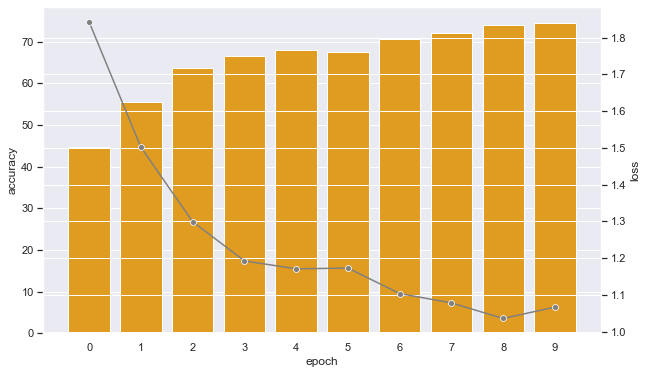

<Figure size 800x480 with 0 Axes>

In [678]:
fig, ax1 = plt.subplots(figsize=(10, 6));
figure(figsize=(10, 6), dpi=80);
sns.barplot(data=results_simple, x='epoch', y='accuracy', ax=ax1, color='orange');
ax2 = ax1.twinx();
sns.lineplot(data=results_simple, x='epoch', y='loss',marker = 'o', ax=ax2, color='gray');

## Convolutional network case
### Set parameters

In [679]:
channels = 1
img_size = 28     
in_size = img_size*img_size*channels
out_size = 26           # number of classes
n_feat = img_size*img_size
epochs = 10       
batch_size = 100
learning_rate = 0.0001
gamma = 1
momentum = 0.9
n_hidden = 512        # number of hidden units


### Define network architecture

In [680]:
 # Gunnika architecture
class convolutional1(nn.Module):
    def __init__(self, in_size, n_hidden, out_size):
        super(convolutional1, self).__init__()
        self.conv1 = nn.Conv2d(channels,15,kernel_size = 3)
        self.conv2 = nn.Conv2d(15,30,kernel_size = 3)
        self.conv3 = nn.Conv2d(30,45,kernel_size = 3)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(0.3)
        
        self.fc1 = nn.Linear(45*3*3, n_hidden)
        self.fc2 = nn.Linear(n_hidden, out_size)
        #self.fc3 = nn.Linear(270, out_size)
        
        self.softmax = nn.LogSoftmax(dim=-1)

    def featurizer(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = nn.Flatten()(x)
        return x

    def classifier(self, x):

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        #x = self.fc3(x)
        #x = F.relu(x)
        
        x = self.softmax(x)
        return x

    def forward(self,x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x
 

### Instantiate and train/test the network model

In [681]:
import torch.optim.lr_scheduler
# instantiate and run nn

model_fnn = convolutional1(in_size, n_hidden, out_size) # convolutional
model_fnn.to(device)
optimizer = torch.optim.Adam(model_fnn.parameters(),lr=learning_rate)

summary(model_fnn, input_size = (channels,img_size,img_size), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 26, 26]             150
         MaxPool2d-2           [-1, 15, 13, 13]               0
            Conv2d-3           [-1, 30, 11, 11]           4,080
         MaxPool2d-4             [-1, 30, 5, 5]               0
            Conv2d-5             [-1, 45, 3, 3]          12,195
         Dropout2d-6             [-1, 45, 3, 3]               0
            Linear-7                  [-1, 512]         207,872
            Linear-8                   [-1, 26]          13,338
        LogSoftmax-9                   [-1, 26]               0
Total params: 237,635
Trainable params: 237,635
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.91
Estimated Total Size (MB): 1.05
-------------------------------------------

In [682]:
results = pd.DataFrame()

for epoch in range(0, epochs):
    temp = pd.DataFrame()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    print('Epoch = '+str(epoch)+' / Learning Rate = ',optimizer.param_groups[0]["lr"])
    
    train(model_fnn, optimizer, train_data_ldr)
    accuracy, loss = test(model_fnn, test_data_ldr)
    
    temp['nn'], temp['epoch'], temp['accuracy'], temp['loss'] = zip(['cnn',epoch,accuracy,loss])
    results = results.append(temp)

    scheduler.step()

results = results.reset_index()
results_cnn = results.drop('index', axis=1)

Epoch = 0 / Learning Rate =  0.0001
 [0/27455] 0% Loss: 5.927959
 [10000/27455] 36% Loss: 2.658681
 [20000/27455] 73% Loss: 1.903612

Test set: Average loss: 1.3357, Accuracy: 4460/7172 (62%)

Epoch = 1 / Learning Rate =  0.0001
 [0/27455] 0% Loss: 1.184410
 [10000/27455] 36% Loss: 0.833534
 [20000/27455] 73% Loss: 0.521066

Test set: Average loss: 0.6538, Accuracy: 5675/7172 (79%)

Epoch = 2 / Learning Rate =  0.0001
 [0/27455] 0% Loss: 0.540440
 [10000/27455] 36% Loss: 0.513863
 [20000/27455] 73% Loss: 0.261748

Test set: Average loss: 0.4555, Accuracy: 6293/7172 (88%)

Epoch = 3 / Learning Rate =  0.0001
 [0/27455] 0% Loss: 0.218090
 [10000/27455] 36% Loss: 0.247746
 [20000/27455] 73% Loss: 0.158733

Test set: Average loss: 0.4166, Accuracy: 6360/7172 (89%)

Epoch = 4 / Learning Rate =  0.0001
 [0/27455] 0% Loss: 0.162183
 [10000/27455] 36% Loss: 0.101509
 [20000/27455] 73% Loss: 0.070595

Test set: Average loss: 0.3901, Accuracy: 6472/7172 (90%)

Epoch = 5 / Learning Rate =  0.0001

### Results
Loss, Accuracy, Confusion matrix

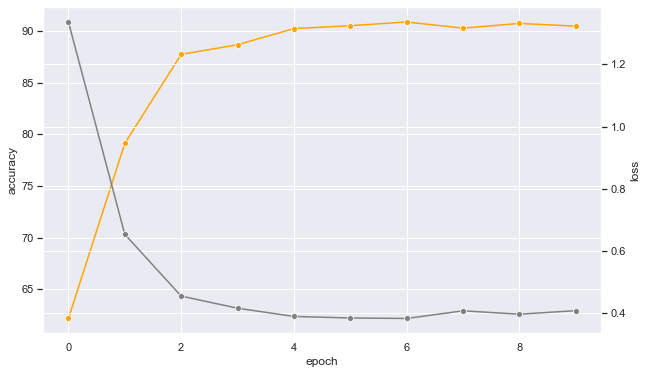

<Figure size 800x480 with 0 Axes>

In [686]:
fig, ax1 = plt.subplots(figsize=(10, 6));
figure(figsize=(10, 6), dpi=80);
sns.lineplot(data=results_cnn, x='epoch', y='accuracy',marker='o', ax=ax1, color='orange');
ax2 = ax1.twinx();
sns.lineplot(data=results_cnn, x='epoch', y='loss',marker='o', ax=ax2, color='gray');

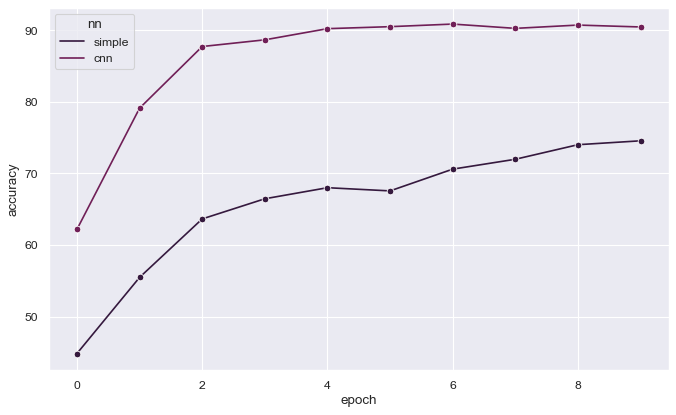

In [684]:
results_all = pd.concat([results_simple, results_cnn]).reset_index()

figure(figsize=(10, 6), dpi=80)
g1 = sns.lineplot(data=results_all, x='epoch', y='accuracy', hue='nn', marker = 'o')